In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [27]:
rental_df = pd.read_csv("toronto_apartment_rentals_2018.csv")

In [28]:
rental_df.head()

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
0,2,2.0,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,"$2,450.00"
1,1,1.0,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,"$2,150.00"
2,1,1.0,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,"$1,950.00"
3,2,2.0,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,"$2,900.00"
4,1,1.0,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,"$1,800.00"


Check data integrity

In [29]:
print(rental_df['Bedroom'].unique())
print(rental_df['Bathroom'].unique())
print(rental_df['Den'].unique())

[2 1 3]
[2.  1.  1.5 3.  2.5]
[0 1]


half bathrooms are two piece (sink and toilet) bathrooms that don't have a shower or bathtub

In [30]:
# check for null values
rental_df.isnull().sum()

Bedroom     0
Bathroom    0
Den         0
Address     0
Lat         0
Long        0
Price       0
dtype: int64

In [31]:
# check data types
rental_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Bedroom   1124 non-null   int64  
 1   Bathroom  1124 non-null   float64
 2   Den       1124 non-null   int64  
 3   Address   1124 non-null   object 
 4   Lat       1124 non-null   float64
 5   Long      1124 non-null   float64
 6   Price     1124 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 61.6+ KB


In [105]:
# change the price column to float datatype
for i in range(rental_df.shape[0]):
    rental_df['Price'][i] = rental_df['Price'][i].replace('$',"")
    rental_df['Price'][i] = rental_df['Price'][i].replace(',',"")

rental_df["Price"] = rental_df['Price'].astype(float)


AttributeError: 'numpy.float64' object has no attribute 'replace'

In [106]:
# make sure the changes are made:
rental_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Bedroom   1124 non-null   int64  
 1   Bathroom  1124 non-null   float64
 2   Den       1124 non-null   int64  
 3   Address   1124 non-null   object 
 4   Lat       1124 non-null   float64
 5   Long      1124 non-null   float64
 6   Price     1124 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 61.6+ KB


In [133]:
rental_df.sort_values(by='Price').head(20)

,Bedroom,Bathroom,Den,Address,Lat,Long,Price,lat_lng
816,1,2.0,0,"Euclid Ave, Toronto, ON, Canada",43.658689,-79.412577,65.0,"[43.658689200000005, -79.4125775]"
973,1,2.0,1,"2121 Lake Shore Blvd W, Etobicoke, ON M8V 4E9,...",43.627447,-79.478374,99.0,"[43.627447100000005, -79.4783741]"
794,1,1.0,0,"8 Wellesley St E, Toronto, ON M4Y 3B2, Canada",43.665233,-79.384293,99.0,"[43.6652335, -79.3842932]"
761,1,1.0,0,", Toronro M4V 1N5 ON, Canada",43.686511,-79.399522,150.0,"[43.686511200000005, -79.39952159999999]"
1110,1,1.0,0,"195 Wynford Dr, North York, ON M3C 3P3, Canada",43.723587,-79.324879,300.0,"[43.723587, -79.32487859999999]"
339,1,1.0,0,"89 Chestnut St, Toronto, ON M5G 1R1, Canada",43.654155,-79.385211,550.0,"[43.6541547, -79.3852113]"
83,1,1.0,0,"89 Chestnut St, Toronto, ON M5G 1R1, Canada",43.654155,-79.385211,550.0,"[43.6541547, -79.3852113]"
204,1,1.0,0,"89 Chestnut St, Toronto, ON M5G 1R1, Canada",43.654155,-79.385211,550.0,"[43.6541547, -79.3852113]"
1049,2,1.0,0,"Bathurst St, Toronto, ON M5S 2P9, Canada",43.658278,-79.408437,600.0,"[43.6582784, -79.40843659999999]"
651,1,1.0,0,", Toronto m5s1x6 ON, Canada",43.665956,-79.404799,650.0,"[43.6659564, -79.4047989]"


Check the relationships between the features

In [110]:
# don't include lat and lng
corr = rental_df.corr()
corr

,Bedroom,Bathroom,Den,Lat,Long,Price
Bedroom,1.000000,0.633783,-0.284351,0.086555,-0.089017,-0.022665
Bathroom,0.633783,1.000000,-0.116509,0.063367,-0.072241,-0.015760
Den,-0.284351,-0.116509,1.000000,0.025667,-0.014885,-0.021426
Lat,0.086555,0.063367,0.025667,1.000000,-0.893854,-0.001124
Long,-0.089017,-0.072241,-0.014885,-0.893854,1.000000,0.001606
Price,-0.022665,-0.015760,-0.021426,-0.001124,0.001606,1.000000


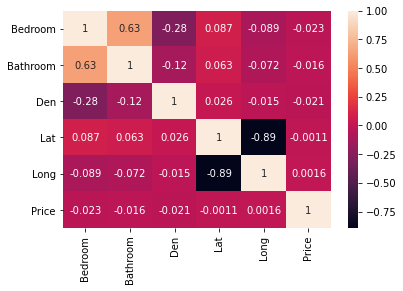

In [111]:
sns.heatmap(corr, annot = True)

In [112]:
from geopy.geocoders import Nominatim
import json
import requests
from pandas.io.json import json_normalize

# import kmeans from clustering stage
from sklearn.cluster import KMeans
import folium

In [113]:
rental_df.shape

(1124, 7)

In [131]:
rental_df.describe()

,Bedroom,Bathroom,Den,Lat,Long,Price
count,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000
mean,1.370107,1.237544,0.153025,43.703532,-79.500326,3627.912811
std,0.553493,0.431997,0.360172,0.692689,1.760654,27530.542058
min,1.000000,1.000000,0.000000,42.985767,-114.082215,65.000000
25%,1.000000,1.000000,0.000000,43.641355,-79.414319,1759.250000
50%,1.000000,1.000000,0.000000,43.650560,-79.387295,2100.000000
75%,2.000000,1.000000,0.000000,43.666613,-79.377198,2500.000000
max,3.000000,3.000000,1.000000,56.130366,-73.576385,535000.000000


In [115]:
# create a lat_lng column
rental_df['lat_lng'] = rental_df[['Lat', 'Long']].values.tolist()

In [129]:
# graph the coordinates
map_toronto = folium.Map(location = rental_df['lat_lng'][0], zoom_start=10)

# add markers to map
for lat,lng,bed,bath,den,address,price in zip(rental_df['Lat'], rental_df['Long'],\
                                       rental_df['Bedroom'],rental_df['Bathroom'],\
                                       rental_df['Den'], rental_df['Address'], rental_df['Price']):
    label = f"Price: {price} \n Bathrooms: {bath} \n Den: {den} \n Bedrooms: {bed}"
    label = folium.Popup(label,parse_html = True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color = "#3186cc",
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)

In [130]:
map_toronto